In [2]:
%%capture --no-stderr
!pip install -U langchain langchain-community langchain-openai langchain-cohere pypdf sentence_transformers chromadb shutil openpyxl FlagEmbedding cohere

In [1]:
%env LLM_API_KEY=替换为自己的千问API Key
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env COHERE_API_KEY=替换为自己的Cohere API Key

env: LLM_API_KEY=替换为自己的千问API Key
env: LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
env: COHERE_API_KEY=替换为自己的Cohere API Key


In [4]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core, cohere

for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, cohere, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

/opt/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-09-02 15:30:55.279988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2024-09-02 15:30:55.280005: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(messa

langchain                     0.2.10
langchain_core                0.2.28
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
cohere                        5.8.0
chromadb                      0.5.4


In [5]:
import os
import pandas as pd

In [6]:
expr_version = 'retrieval_v5_rerank'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 读取文档

In [7]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [8]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [9]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [10]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [11]:
import jieba
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma
from langchain.retrievers import BM25Retriever, EnsembleRetriever

# 如果已下载，可以替换为本机路径
model_path = 'stevenluo/bge-large-zh-v1.5-ft-v4'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)
chz_cut_bm25_retriever = BM25Retriever.from_documents(splitted_docs, preprocess_func=lambda text: list(jieba.cut(text)))

def build_get_ensemble_retriver_fn(weights=[0.5, 0.5]):
    return lambda k: EnsembleRetriever(
        retrievers=[vector_db.as_retriever(search_kwargs={'k': k}), chz_cut_bm25_retriever], weights=weights
    )

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.491 seconds.
Prefix dict has been built successfully.


## 计算没有Reranker的准确率

In [12]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [13]:
def get_hit_stat_df(get_retriever_fn, top_k_arr=list(range(1, 9))):
    hit_stat_data = []

    for k in tqdm(top_k_arr):
        retriever = get_retriever_fn(k)
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = retrieve_fn(question, k=k)
            chunks = retriever.get_relevant_documents(question)[:k]
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [14]:
retriever_only_hit_stat_df = get_hit_stat_df(build_get_ensemble_retriver_fn(weights=[0.5, 0.5]))

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [15]:
retriever_only_hit_stat_df.groupby(['top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,top_k,hit_rate
0,1,0.548387
1,2,0.752688
2,3,0.870968
3,4,0.892473
4,5,0.913978
5,6,0.935484
6,7,0.946237
7,8,0.967742


<Axes: xlabel='top_k', ylabel='hit'>

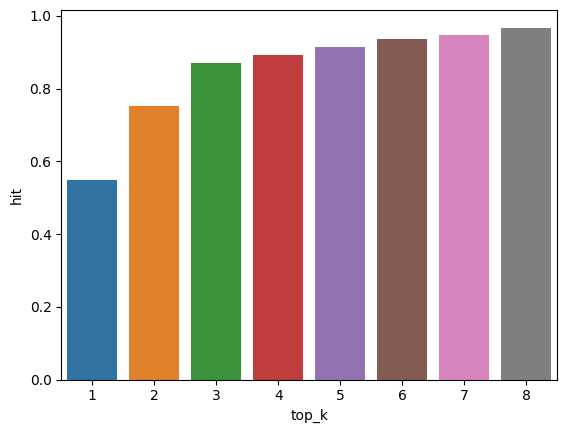

In [16]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', data=retriever_only_hit_stat_df, errorbar=None)

## 加Reranker

### Coheree Rerank

官方样例

```python
import cohere

co = cohere.Client("<<apiKey>>")

docs = [
    "Carson City is the capital city of the American state of Nevada.",
    "The Commonwealth of the Northern Mariana Islands is a group of islands in the Pacific Ocean. Its capital is Saipan.",
    "Capitalization or capitalisation in English grammar is the use of a capital letter at the start of a word. English usage varies from capitalization in other languages.",
    "Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.",
    "Capital punishment (the death penalty) has existed in the United States since beforethe United States was a country. As of 2017, capital punishment is legal in 30 of the 50 states.",
]

response = co.rerank(
    model="rerank-multilingual-v3.0",
    query="What is the capital of the United States?",
    documents=docs,
    top_n=3,
)
print(response)
```

```bash
curl --request POST \
  --url https://api.cohere.com/v1/rerank \
  --header 'accept: application/json' \
  --header 'content-type: application/json' \
  --header "Authorization: bearer <api_key>" \
  --data '{
    "model": "rerank-english-v3.0",
    "query": "What is the capital of the United States?",
    "top_n": 3,
    "documents": ["Carson City is the capital city of the American state of Nevada.",
                  "The Commonwealth of the Northern Mariana Islands is a group of islands in the Pacific Ocean. Its capital is Saipan.",
                  "Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.",
                  "Capitalization or capitalisation in English grammar is the use of a capital letter at the start of a word. English usage varies from capitalization in other languages.",
                  "Capital punishment (the death penalty) has existed in the United States since beforethe United States was a country. As of 2017, capital punishment is legal in 30 of the 50 states."]
```
resp
```json
{"id":"0b91f9b5-fb76-468c-977b-e403c7cc4113","results":[{"index":2,"relevance_score":0.999071},{"index":4,"relevance_score":0.7867867},{"index":0,"relevance_score":0.32713068}],"meta":{"api_version":{"version":"1"},"billed_units":{"search_units":1}}}
```

使用Cohere Rerank在线API服务，需要有代理服务

In [17]:
%env http_proxy=http://192.168.31.71:4780
%env https_proxy=http://192.168.31.71:4780

env: http_proxy=http://192.168.31.71:4780
env: https_proxy=http://192.168.31.71:4780


In [18]:
from langchain_cohere import CohereRerank

cohere_rerank = CohereRerank(model="rerank-english-v3.0")

试用一下

In [19]:
# API用量用完了

# docs = [
#     "Carson City is the capital city of the American state of Nevada.",
#     "The Commonwealth of the Northern Mariana Islands is a group of islands in the Pacific Ocean. Its capital is Saipan.",
#     "Capitalization or capitalisation in English grammar is the use of a capital letter at the start of a word. English usage varies from capitalization in other languages.",
#     "Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.",
#     "Capital punishment (the death penalty) has existed in the United States since beforethe United States was a country. As of 2017, capital punishment is legal in 30 of the 50 states.",
# ]
# query = "What is the capital of the United States?"
# cohere_rerank.rerank(
#     documents=docs,
#     query=query,
#     top_n=None
# )

重新封装一下，以便统一本地和Cohere的Rerank

In [20]:
import time

class LangchainCohereRerank:
    def __init__(self, api_key=None, model='rerank-multilingual-v3.0'):
        if api_key is not None:
            os.environ['COHERE_API_KEY'] = api_key
        if os.environ.get('COHERE_API_KEY') is None:
            raise ValueError('api_key not provided! export COHERE_API_KEY environment variable os pass api_key during construct!')
            
        self.cohere_rerank = CohereRerank(model=model)

    def compute_score(self, query_documents, max_retry=5):
        query_docs_dict = {}
        for query, doc in query_documents:
            if query not in query_docs_dict:
                query_docs_dict[query] = []
            query_docs_dict[query].append(doc)
        
        ret = []
        for query, docs in query_docs_dict.items():
            scores = [0] * len(docs)
            """
            resp样例：
            [{'index': 3, 'relevance_score': 0.999071},
             {'index': 4, 'relevance_score': 0.7867867},
             {'index': 0, 'relevance_score': 0.32713068}]
            """
            while max_retry > 0:
                try:
                    resp = cohere_rerank.rerank(
                        query=query,
                        documents=docs,
                        top_n=None
                    )
                    for item in resp:
                        scores[item['index']] = item['relevance_score']
                    ret.extend(scores)
                    break
                except Exception as e:
                    max_retry -= 1
                    sleep_s = 20 + 2 ** (8 - max_retry)
                    print(f"query: {query}, error: {e} doc count: {len(docs)}, sleeping {sleep_s}s, retry left {max_retry}")
                    time.sleep(sleep_s)
        return ret

In [21]:
# API用量用完了

# LangchainCohereRerank().compute_score(
#     [[query, doc] for doc in docs]
# )

可以看到，返回结果，和上面对应index位置的值是相等的

### GTE Reranker

官方样例，https://huggingface.co/Alibaba-NLP/gte-multilingual-reranker-base：

```python
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name_or_path = "Alibaba-NLP/gte-multilingual-reranker-base"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path, trust_remote_code=True,
    torch_dtype=torch.float16
)
model.eval()

pairs = [["中国的首都在哪儿"，"北京"], ["what is the capital of China?", "北京"], ["how to implement quick sort in python?","Introduction of quick sort"]]
with torch.no_grad():
    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
    scores = model(**inputs, return_dict=True).logits.view(-1, ).float()
    print(scores)

# tensor([1.2315, 0.5923, 0.3041])
```

Langchain中有一个HuggingFaceCrossEncoder也可以CrosssEncoder，但GTE官方样例没有提到说可以使用Langchain的HuggingFaceCrossEncoder计算。

```python
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

reranker = HuggingFaceCrossEncoder(
    model_name=model_name_or_path,
    model_kwargs={'trust_remote_code': True}
)
reranker.score(pairs)
# array([0.7744, 0.644 , 0.5757], dtype=float16)
```

观察两者输出，值并不相同，但排序关系是一致的，通过阅读langchain源代码`CrossEncoder.py`可以发现，`HuggingFaceCrossEncoder`的score结果，只是GTE官方结果，过了一个sigmoid。
也就是`torch.sigmoid(torch.tensor([1.2315, 0.5923, 0.3041]))`

上面提到，虽然使用HuggingFaceCrossEncoder的score也可以获取排序结果，但为了跟后面的流程保持相同接口，下面还是进行简单封装

In [22]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

class HuggingfaceReranker:
    def __init__(self, model_name, model_kwargs: dict):
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)
        self._model = AutoModelForSequenceClassification.from_pretrained(
            model_name, **model_kwargs
        )

    def compute_score(self, pairs):
        if hasattr(self._model, 'compute_score'):
            return self._model.compute_score(pairs)

        with torch.no_grad():
            inputs = self._tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = inputs.to(self._model.device)
            scores = self._model(**inputs, return_dict=True).logits.view(-1, ).float()
        return scores.cpu().numpy()

In [23]:
# 此处可以替换为本地绝对路径
gte_model_path = 'AlibabaNLP/gte-multilingual-reranker-base'

reranker = HuggingfaceReranker(gte_model_path, model_kwargs={'trust_remote_code': True, 'torch_dtype': torch.float16})

### Jina Reranker

上面介绍的Cohere Rerank，其实就是Jina的，此处介绍的是开源模型

官方示例，https://huggingface.co/jinaai/jina-reranker-v2-base-multilingual

```python
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    'jinaai/jina-reranker-v2-base-multilingual',
    torch_dtype="auto",
    trust_remote_code=True,
)

model.to('cuda') # or 'cpu' if no GPU is available
model.eval()

# Example query and documents
query = "Organic skincare products for sensitive skin"
documents = [
    "Organic skincare for sensitive skin with aloe vera and chamomile.",
    "New makeup trends focus on bold colors and innovative techniques",
    "Bio-Hautpflege für empfindliche Haut mit Aloe Vera und Kamille",
    "Neue Make-up-Trends setzen auf kräftige Farben und innovative Techniken",
    "Cuidado de la piel orgánico para piel sensible con aloe vera y manzanilla",
    "Las nuevas tendencias de maquillaje se centran en colores vivos y técnicas innovadoras",
    "针对敏感肌专门设计的天然有机护肤产品",
    "新的化妆趋势注重鲜艳的颜色和创新的技巧",
    "敏感肌のために特別に設計された天然有機スキンケア製品",
    "新しいメイクのトレンドは鮮やかな色と革新的な技術に焦点を当てています",
]

# construct sentence pairs
sentence_pairs = [[query, doc] for doc in documents]

scores = model.compute_score(sentence_pairs, max_length=1024)
```

### 不同Rerank效果对比

In [24]:
def rerank(reranker, query, retrieved_docs, top_k=5, debug=False):
    rerank_scores = reranker.compute_score([[query, doc.page_content] for doc in retrieved_docs])
    triads = [(query, doc, score) for doc, score in zip(retrieved_docs, rerank_scores)]
    triads = sorted(triads, key=lambda triad: triad[-1], reverse=True)
    if debug:
        return triads
    return [triad[1] for triad in triads][:top_k]

In [25]:
from FlagEmbedding import FlagReranker

def get_hit_stat_df(get_retriever_fn, reranker, retirever_multiplier=3):
    hit_stat_data = []
    
    top_k_arr = list(range(1, 9))
    for k in tqdm(top_k_arr):
        retriever = get_retriever_fn(k * retirever_multiplier)
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            chunks = retriever.get_relevant_documents(question)[:k * retirever_multiplier]
            chunks = rerank(reranker, question, chunks, top_k=k)
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks][:k]
    
            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

def get_reranker(path):
    """
    屏蔽不同Reranker的差异，封装一个同一个的类获取这些Reranker的示例
    """
    
    if path is None:
        return LangchainCohereRerank()
    if 'bge' in path.lower():
        return FlagReranker(path, use_fp16=True)
    else:
        return HuggingfaceReranker(path, model_kwargs={'trust_remote_code': True, 'torch_dtype': torch.float16, 'device_map': device})

In [26]:
reranker_dict = {
    'cohere-rerank': None,
    
    # 此处可以替换为本地绝对路径
    'bge-reranker-base': 'BAAI/bge-reranker-base',
    'bge-reranker-large': 'BAAI/bge-reranker-large',
    'bge-reranker-v2-m3': 'BAAI/bge-reranker-v2-m3',
    'gte-reranker': 'AlibabaNLP/gte-multilingual-reranker-base',
    'jina-reranker': 'jinaai/jina-reranker-v2-base-multilingual'
}

In [27]:
with_reranker_hit_stat_dfs = []

In [28]:
from FlagEmbedding import FlagReranker

# 获取Embedding检索器的方法，返回值依然是一个函数，因为还要设置片段数量
get_retriever_fn = build_get_ensemble_retriver_fn(weights=[0.5, 0.5])

for reranker_name in reranker_dict:
    # API用量用完了，先跳过
    if reranker_name == 'cohere-rerank':
        continue

    model_path = reranker_dict[reranker_name]
    reranker = get_reranker(model_path)
    hit_stat_df = get_hit_stat_df(get_retriever_fn, reranker)
    hit_stat_df['reranker'] = f'w/ {reranker_name}'
    with_reranker_hit_stat_dfs.append(hit_stat_df)

    # 释放显存
    torch.cuda.empty_cache()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.


  0%|          | 0/8 [00:00<?, ?it/s]

In [29]:
with_reranker_hit_stat_df = pd.concat(with_reranker_hit_stat_dfs)

In [65]:
with_reranker_hit_stat_df.groupby(['reranker', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,reranker,top_k,hit_rate
0,w/ bge-reranker-base,1,0.709677
1,w/ bge-reranker-base,2,0.817204
2,w/ bge-reranker-base,3,0.870968
3,w/ bge-reranker-base,4,0.924731
4,w/ bge-reranker-base,5,0.924731
5,w/ bge-reranker-base,6,0.935484
6,w/ bge-reranker-base,7,0.946237
7,w/ bge-reranker-base,8,0.956989
8,w/ bge-reranker-large,1,0.741935
9,w/ bge-reranker-large,2,0.860215


In [66]:
retriever_only_hit_stat_df['reranker'] = 'w/o'
hit_stat_df = pd.concat([retriever_only_hit_stat_df, with_reranker_hit_stat_df])

<Axes: xlabel='top_k', ylabel='hit'>

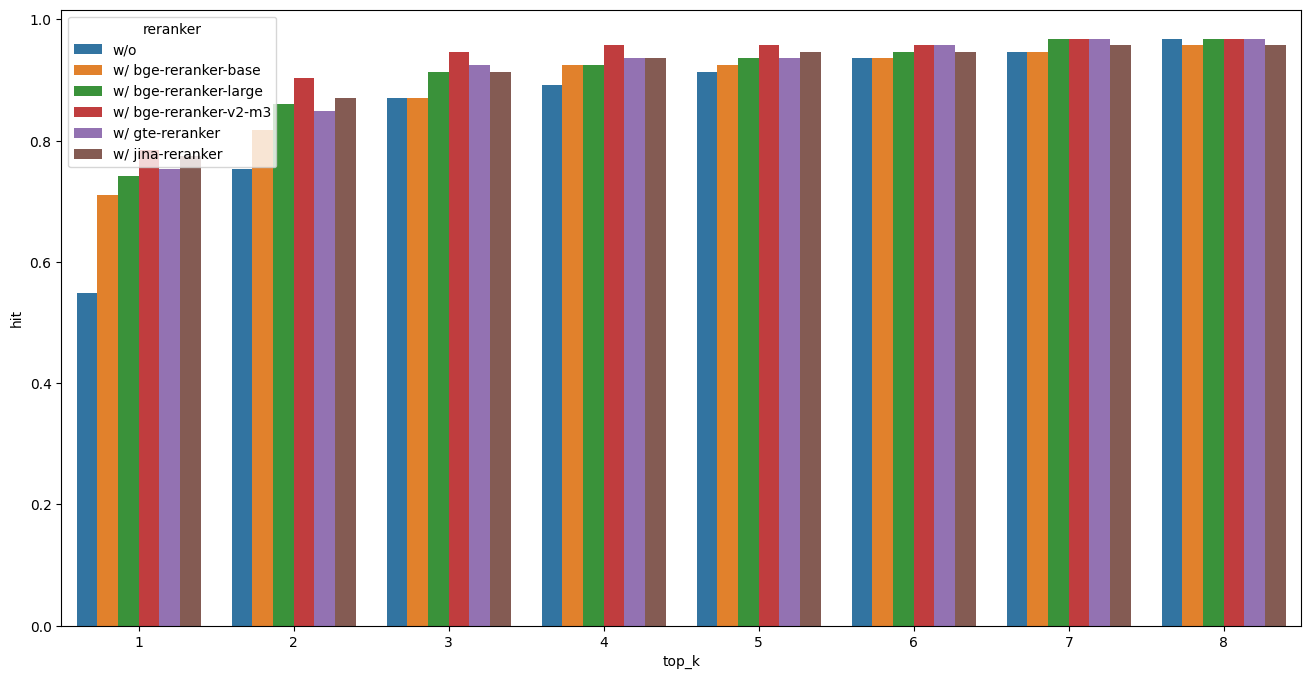

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.barplot(x='top_k', y='hit', hue='reranker', data=hit_stat_df, errorbar=None)

# 预测

In [33]:
from langchain.llms import Ollama

llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434',
    temperature=0
)

In [34]:
def rag(retriever, reranker, query, n_chunks=4, retirever_multiplier=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()

    chunks = retriever.invoke(query)[:n_chunks * retirever_multiplier]
    chunks = rerank(reranker, query, chunks, top_k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)

    return llm(prompt), chunks

In [35]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(prediction_df, retriever, reranker, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(retriever, reranker, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [36]:
%env http_proxy=
%env https_proxy=

env: http_proxy=
env: https_proxy=


In [37]:
pred_dict = {}

In [43]:
n_chunks = 3

get_retriever_fn = build_get_ensemble_retriver_fn(weights=[0.5, 0.5])
retriever = get_retriever_fn(n_chunks)

for reranker_name, reranker_path in reranker_dict.items():
    # API用量用完了，先跳过
    if reranker_name == 'cohere-rerank':
        continue

    if reranker_name in pred_dict:
        continue

    model_path = reranker_dict[reranker_name]
    reranker = get_reranker(model_path)
    pred_df = predict(prediction_df, retriever, reranker, n_chunks=n_chunks)

    pred_dict[reranker_name] = pred_df
    
    # 释放显存
    torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.


  0%|          | 0/100 [00:00<?, ?it/s]

# 评估 

In [57]:
from langchain_openai import ChatOpenAI

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

import time

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()

        retry_count = 3
        result = None
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except:
                time.sleep(4 ** (5 - retry_count))
                retry_count -= 1

        if result is None:
            print(f'question={question}, scoring failed!')
        results.append(result)
        
        time.sleep(1)
    return results

In [58]:
for reranker_name in pred_dict:
    pred_df = pred_dict[reranker_name]
    pred_df['raw_score'] = evaluate(pred_df)
    print(f"{reranker_name}: {pred_df['raw_score'].unique()}")
    pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
    
    time.sleep(4)

  0%|          | 0/100 [00:00<?, ?it/s]

bge-reranker-base: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

base-reranker-large: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

bge-reranker-v2-m3: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

gte-reranker: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

jina-reranker: ['是' '否']


In [59]:
metrics = []

for reranker_name in pred_dict:
    pred_df = pred_dict[reranker_name]
    metrics.append({
        'reranker': reranker_name,
        'score': pred_df['score'].mean()
    })

In [60]:
pd.DataFrame(metrics)

,reranker,score
0,bge-reranker-base,0.80
1,base-reranker-large,0.84
2,bge-reranker-v2-m3,0.81
3,gte-reranker,0.87
4,jina-reranker,0.80
